In [23]:
import zipfile
import os
import pandas as pd
import requests
import deflatebr as dbr

In [51]:
def concatenar_csvs(diretorio):
    frames = []

    for arquivo in os.listdir(diretorio):
        if arquivo.endswith('.csv'):
            caminho_arquivo = os.path.join(diretorio, arquivo)
            
            df = pd.read_csv(caminho_arquivo, encoding='utf-8', delimiter=";", decimal=",")
            df = df.rename(columns={df.columns[0]: "data_base"})
            df['data_base'] = pd.to_datetime(df['data_base'], format="%Y-%m-%d")
            df = df[df['cliente'] == "PF"]
            df['porte'] = df['porte'].str.replace(' ','')
            df = df[['data_base', 'porte', 'a_vencer_de_361_ate_1080_dias', 'a_vencer_de_1081_ate_1800_dias', 'a_vencer_de_1801_ate_5400_dias', 'a_vencer_acima_de_5400_dias']]
            #Nova coluna para endividamento de curto prazo
            df['longo_prazo'] = df['a_vencer_de_361_ate_1080_dias'] + df['a_vencer_de_1081_ate_1800_dias'] + df['a_vencer_de_1801_ate_5400_dias'] + df['a_vencer_acima_de_5400_dias']
            df = df.drop(columns = ['a_vencer_de_361_ate_1080_dias', 'a_vencer_de_1081_ate_1800_dias', 'a_vencer_de_1801_ate_5400_dias', 'a_vencer_acima_de_5400_dias'], axis = 1)
            df['data_base'] = df['data_base'].dt.strftime('%Y-%m')
            #Agrupamentos para análise
            df = df.groupby(['data_base','porte'])['longo_prazo'].sum().reset_index()
            
            frames.append(df)

    df_concatenado = pd.concat(frames, ignore_index=True)

    return df_concatenado

In [52]:
anos = list(range(2012, 2024))
dataframes = []

for ano in anos:
    diretorio = f"planilha_{ano}"
    dataframe_ano = concatenar_csvs(diretorio)
    dataframes.append(dataframe_ano)

df_total = pd.concat(dataframes, ignore_index=False)

In [53]:
df_total.columns

Index(['data_base', 'porte', 'longo_prazo'], dtype='object')

In [54]:
df_total.head(3)

,data_base,porte,longo_prazo
0,2012-06,PF-Acimade20saláriosmínimos,235805947464.45
1,2012-06,PF-Até1saláriomínimo,30450185405.23
2,2012-06,PF-Indisponível,3787531726.99


In [55]:
df_total['longo_prazo_deflacionado'] = dbr.deflate(nominal_values=df_total['longo_prazo'], nominal_dates=df_total['data_base'], real_date='2022-01')

/Users/brunamoura/anaconda3/lib/python3.11/site-packages/deflatebr/deflate.py:90: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [56]:
pd.set_option('display.float_format', '{:.2f}'.format)
df_total.head(3)

,data_base,porte,longo_prazo,longo_prazo_deflacionado
0,2012-06,PF-Acimade20saláriosmínimos,235805947464.45,416942595930.97
1,2012-06,PF-Até1saláriomínimo,30450185405.23,53840793609.97
2,2012-06,PF-Indisponível,3787531726.99,6696961325.20


In [57]:
url = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.24369/dados?formato=json'

taxa_desocupacao = requests.get(url).json() 

taxa_desocupacao[100]

{'data': '01/07/2020', 'valor': '14.1'}

In [58]:
desocupacao_df = pd.DataFrame(taxa_desocupacao)

In [59]:
desocupacao_df['data'] = pd.to_datetime(desocupacao_df['data'], format = "%d/%m/%Y")

In [60]:
desocupacao_df['data'] = desocupacao_df['data'].dt.strftime('%Y-%m')

In [61]:
desocupacao_df.head(3)

,data,valor
0,2012-03,8.0
1,2012-04,7.8
2,2012-05,7.7


In [62]:
df_desemprego_divida = pd.merge(desocupacao_df,
                              df_total,
                              left_on="data",
                              right_on="data_base",
                              how = "inner")

In [63]:
df_desemprego_divida = df_desemprego_divida.drop(columns = ['data_base', 'longo_prazo'])

In [64]:
df_desemprego_divida.head(3)

,data,valor,porte,longo_prazo_deflacionado
0,2012-06,7.6,PF-Acimade20saláriosmínimos,416942595930.97
1,2012-06,7.6,PF-Até1saláriomínimo,53840793609.97
2,2012-06,7.6,PF-Indisponível,6696961325.20


In [65]:
import plotly.graph_objects as go

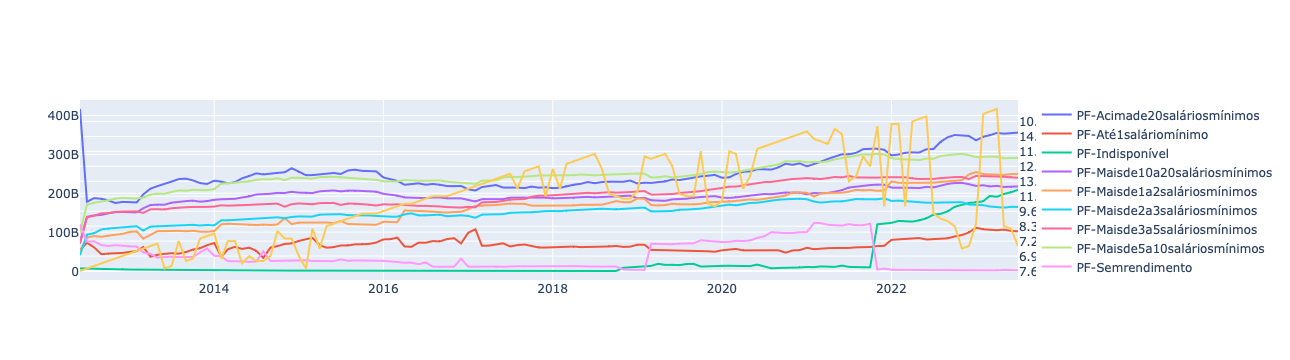

In [68]:
fig = go.Figure()

for porte in df_desemprego_divida['porte'].unique():
    subset = df_desemprego_divida[df_desemprego_divida['porte'] == porte]
    fig.add_trace(go.Scatter(x=subset['data'],
                             y=subset['longo_prazo_deflacionado'],
                             mode='lines',
                             name=f'{porte}'))

# Adicionando a coluna 'valor' ao segundo eixo y
fig.add_trace(go.Scatter(x=df_desemprego_divida['data'],
                         y=df_desemprego_divida['valor'], 
                         mode='lines',
                         name='Taxa de desocupação',
                         yaxis='y2'))

fig.update_layout(yaxis2=dict(overlaying='y',
                              side='right'))

fig.show()

In [69]:
df_desemprego_divida['porte'].unique()

array(['PF-Acimade20saláriosmínimos', 'PF-Até1saláriomínimo',
       'PF-Indisponível', 'PF-Maisde10a20saláriosmínimos',
       'PF-Maisde1a2saláriosmínimos', 'PF-Maisde2a3saláriosmínimos',
       'PF-Maisde3a5saláriosmínimos', 'PF-Maisde5a10saláriosmínimos',
       'PF-Semrendimento'], dtype=object)

In [77]:
def categoria_renda(dados_porte):
    if dados_porte in ['PF-Acimade20saláriosmínimos', 'PF-Mais de 10a20saláriosmínimos', 'PF-Maisde5a10saláriosmínimos']:
        return 'alta renda'
    elif dados_porte == 'PF-Sem rendimento':
        return 'sem rendimento'
    elif dados_porte == 'PF-Indisponível':
        return 'renda indisponível'
    elif dados_porte == 'PF-Maisde3a5saláriosmínimos':
        return 'renda média'
    else:
        return 'baixa renda'

df_desemprego_divida['categoria_renda'] = df_desemprego_divida['porte'].apply(categoria_renda)

In [82]:
df_desemprego_divida.head(10)

,data,valor,porte,longo_prazo_deflacionado,categoria_renda
0,2012-06,7.6,PF-Acimade20saláriosmínimos,416942595930.97,alta renda
1,2012-06,7.6,PF-Até1saláriomínimo,53840793609.97,baixa renda
2,2012-06,7.6,PF-Indisponível,6696961325.20,renda indisponível
3,2012-06,7.6,PF-Maisde10a20saláriosmínimos,74896553347.39,baixa renda
4,2012-06,7.6,PF-Maisde1a2saláriosmínimos,51531093389.25,baixa renda
5,2012-06,7.6,PF-Maisde2a3saláriosmínimos,40910852671.89,baixa renda
6,2012-06,7.6,PF-Maisde3a5saláriosmínimos,70609110525.33,renda média
7,2012-06,7.6,PF-Maisde5a10saláriosmínimos,98994429637.65,alta renda
8,2012-06,7.6,PF-Semrendimento,120230048168.74,baixa renda
9,2012-07,7.5,PF-Acimade20saláriosmínimos,178085338965.30,alta renda


In [91]:
df_desemprego_divida_grupo = df_desemprego_divida.groupby(['data','categoria_renda'])['longo_prazo_deflacionado'].sum().reset_index()

In [94]:
desocupacao_df.head(5)

,data,valor
0,2012-03,8.0
1,2012-04,7.8
2,2012-05,7.7
3,2012-06,7.6
4,2012-07,7.5


In [96]:
df_desemprego_divida_grupo = pd.merge(df_desemprego_divida_grupo,
                              desocupacao_df,
                              how = "inner")

In [97]:
df_desemprego_divida_grupo.head(4)

,data,categoria_renda,longo_prazo_deflacionado,valor
0,2012-06,alta renda,515937025568.62,7.6
1,2012-06,baixa renda,341409341187.24,7.6
2,2012-06,renda indisponível,6696961325.20,7.6
3,2012-06,renda média,70609110525.33,7.6


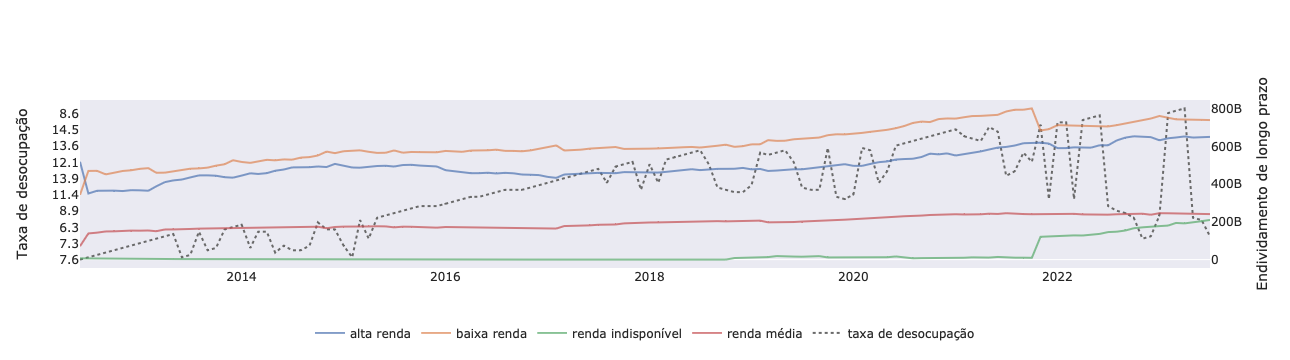

In [147]:
fig = go.Figure()

for categoria_renda in df_desemprego_divida_grupo['categoria_renda'].unique():
    subset = df_desemprego_divida_grupo[df_desemprego_divida_grupo['categoria_renda'] == categoria_renda]
    fig.add_trace(go.Scatter(x=subset['data'],
                             y=subset['longo_prazo_deflacionado'],
                             mode='lines',
                             name=f'{categoria_renda}',
                             yaxis='y2',
                             opacity=0.7))

fig.add_trace(go.Scatter(x=df_desemprego_divida_grupo['data'],
                         y=df_desemprego_divida_grupo['valor'], 
                         mode='lines',
                         name='taxa de desocupação',
                         opacity=1,
                        line=dict(color='dimgray', width=2, dash='dot')))

fig.update_layout(yaxis2=dict(overlaying='y',
                              side='right',
                             showgrid=False,
                             title = "Endividamento de longo prazo"),
                 template="seaborn",
                  legend=dict(x = 0.5,
                              y = -0.3,
                              orientation='h',
                              xanchor='center'),
                 xaxis=dict(showgrid=False),
                 yaxis=dict(showgrid=False,
                           title = "Taxa de desocupação"))

fig.show()